In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle 
import datetime 
import matplotlib.dates as mdates
import xarray as xr
import glob 
import cartopy

# Load in custom helper functions: 
import sys 
sys.path.append('/Users/annpu/GitDirs/4DG_meltmaps/scripts/')
from load_data import open_pickle, icemask_from_tif, make_data_mask, read_tif
from helper_tools import compute_melt_extent, number_of_meltdays, compute_max_melt_extent, plot_greenland, plot_melt_volume

# Difine where to find data: 
home_dir = '/Volumes/disk3s1/enveo/'

# load a random scene and convert it to the an icemask: 
ascat_mask = icemask_from_tif(home_dir + '/ASCAT/2020/meltmap_v02_2020-01-02.tif')
ascat_mask[ascat_mask == 0] = 1 # Set 0 to 1. 

# Load grid (used for plotting); 
grid = xr.open_dataset(home_dir + '/tif_grid.nc')
grid_X, grid_Y = np.meshgrid(grid.x,grid.y)
plot_proj = cartopy.crs.Stereographic(central_longitude=-45,central_latitude=90,true_scale_latitude=70)

# Load in datamask: 
mask, unmasked =  make_data_mask(home_dir)

# Define colors: 
color_racmo =  (208/255,28/255,31/255)
color_mar = (225/255,126/255,4/255)
color_hirham5 = (47/255,158/255,49/255) 
color_hirhami = (74/255,130/255,191/255)

## Compute the melt extent for all RCMs and ASCAT

2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2020


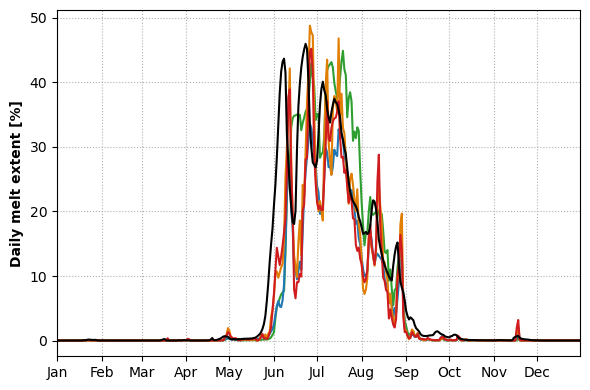

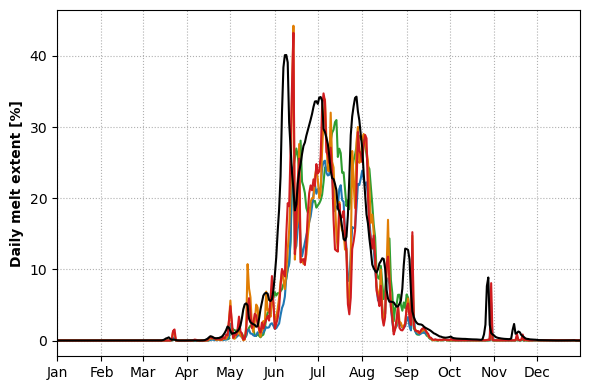

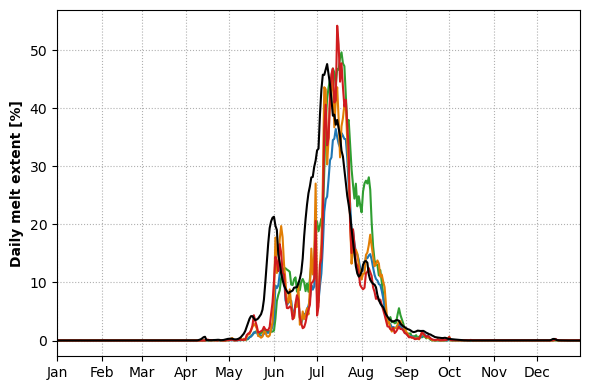

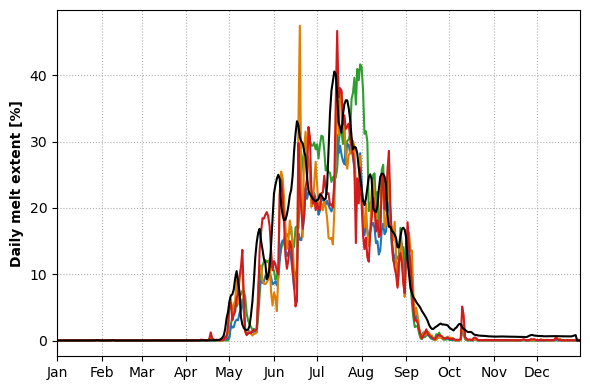

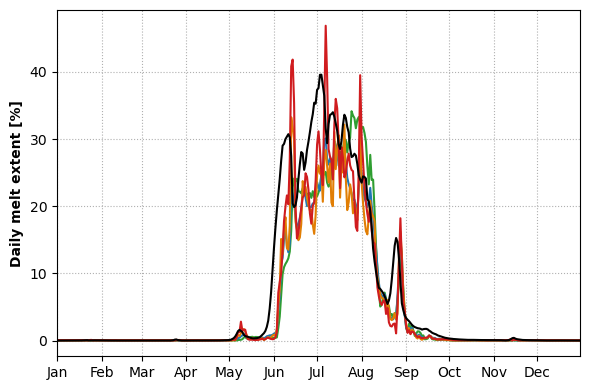

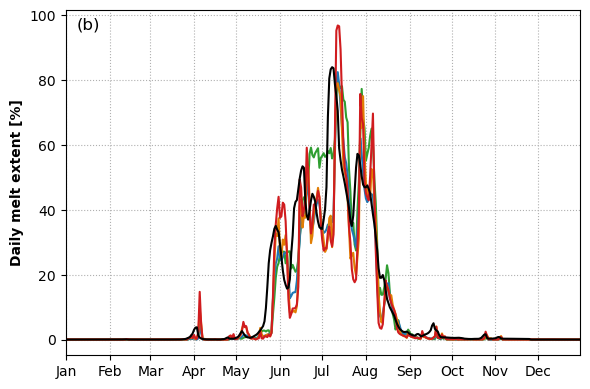

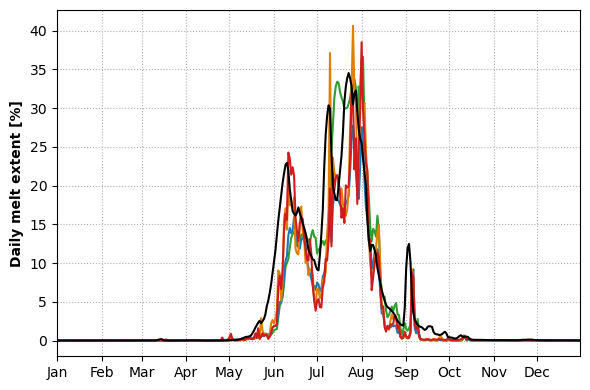

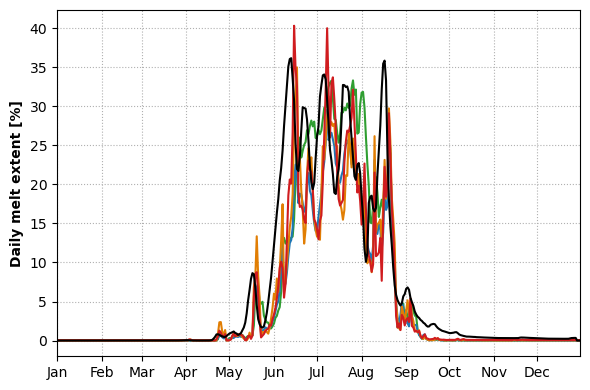

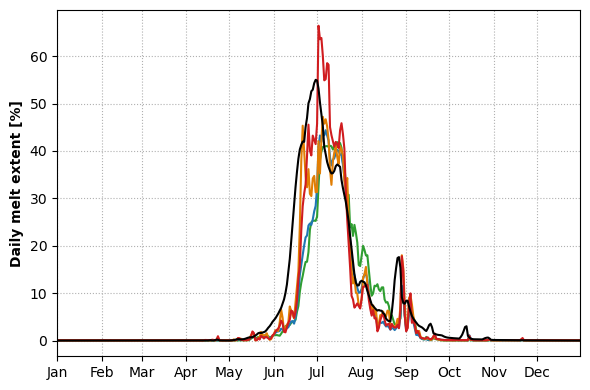

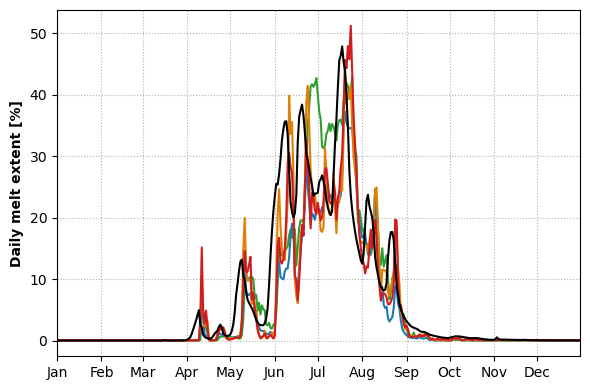

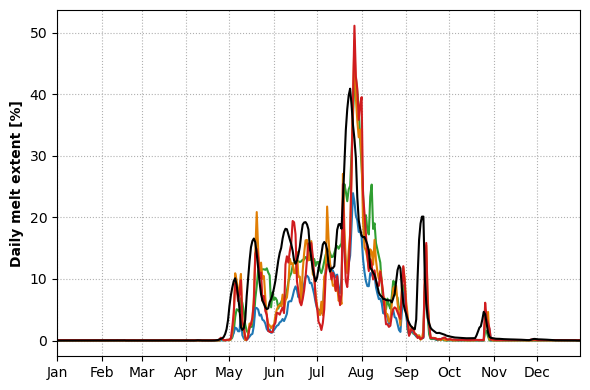

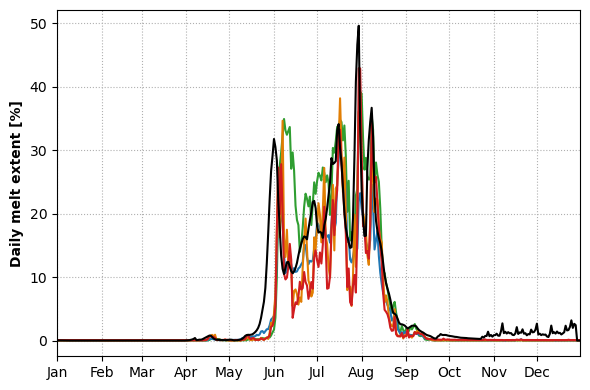

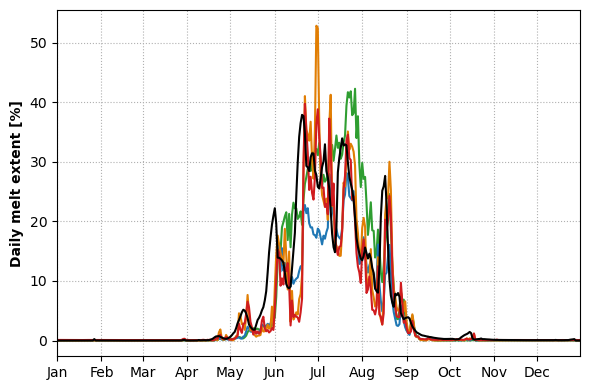

In [3]:

# Init arrays to store the data:
hirham_era5_sum = []
hirham_erai_sum = []
carra_sum = []
mar_sum = []
racmo_sum = []
max_melt_extent = []
daily_melt_extent = []


# Now run one year at a time: 
for year in range(2007, 2021): 
    if year == 2019: 
        continue
    print(year)
    # Load in regridded RCMs:
    hirham_era5 = open_pickle(home_dir + f'/regriddedRCM/HIRHAM_ERA5_v2_{year}_regridded_nearest.pkl')
    hirham_erai = open_pickle(home_dir + f'/regriddedRCM/HIRHAM_{year}_regridded_nearest.pkl')
    racmo = open_pickle(home_dir + f'/regriddedRCM/RACMO_{year}_regridded_nearest.pkl')
    mar = open_pickle(home_dir + f'/regriddedRCM/MAR_{year}_regridded_cubic.pkl')

   
    ascat = []
     # define the daterange for that year: 
    dates_ascat = pd.date_range(datetime.date(year,1, 1), periods = racmo.shape[0])
    for date in dates_ascat: 
        date_str = date.strftime('%Y-%m-%d')
        # Find file: 
        file = glob.glob(home_dir + f'/ASCAT/{year}/meltmap_v02_{date_str}.tif')
        # if there is no file then make it completely no melt. This can only be done since the meltmaps already have 
         # filled datagaps and therefore only a few winter days are missing (except for 2019 where summer data is missing)
        if len(file) == 0: 
            tif = np.copy(ascat_mask)
            tif[tif == 1] = 0
         # if there is a file then open it: 
        else: 
            tif = read_tif(file[0])
            tif[tif >= 5] = np.nan # Set bedrock and ocean to nan. 
        
        ascat.append(tif) # Append to data array    
        # np.
    ascat = np.array(ascat)  
    
    
   #  # Compute the number of days where melt is over the specified threshold:
    meltdays_racmo = number_of_meltdays(racmo,0.1)
    meltdays_hirham_era5 = number_of_meltdays(hirham_era5,0.1)
    meltdays_hirham_erai = number_of_meltdays(hirham_erai,0.1)
    meltdays_mar = number_of_meltdays(mar,0.1)

     # Compute number of melt days for ASCAT 
    melt_ascat = np.zeros(ascat.shape)
    melt_ascat[(ascat >= 1) & (ascat <= 2)] = 1
    meltdays_ascat = np.sum(melt_ascat, axis = 0)
    meltdays_ascat[meltdays_ascat==0] = np.nan
    meltdays_ascat = meltdays_ascat *mask
    melt_extent_ascat = np.sum(melt_ascat.reshape(melt_ascat.shape[0], -1), axis = 1)
    max_extent_ascat = np.max(melt_extent_ascat/59959*100)

    
    max_melt_hirham_era5 = compute_max_melt_extent(meltdays_hirham_era5, ascat_mask)
    max_melt_hirham_erai = compute_max_melt_extent(meltdays_hirham_erai, ascat_mask)
    max_melt_racmo = compute_max_melt_extent(meltdays_racmo, ascat_mask)
    max_melt_mar = compute_max_melt_extent(meltdays_mar, ascat_mask)
    max_extent_ascat = compute_max_melt_extent(meltdays_ascat, ascat_mask)
    
    if year >= 2006:
         dates = pd.date_range(f'01-01-{year}', end = f'31-12-{year}')
         fig, ax = plt.subplots(1, 1, figsize = (6, 4))
         ax.plot(dates, compute_melt_extent(hirham_era5*mask, 4.1), label = 'HIRHAM-ERA5', color = color_hirham5)
         ax.plot(dates, compute_melt_extent(hirham_erai*mask,0.4), label = 'HIRHAM-ERAI')

         ax.plot(dates, compute_melt_extent(mar*mask, 1), label = 'MARv3.12', color = color_mar)
         ax.plot(dates, compute_melt_extent(racmo*mask, 0.7), label = 'RACMO2.3p2', color = color_racmo)
         ax.plot(dates,melt_extent_ascat/59959*100, color = 'black', linewidth = 1.5, label = 'ASCAT')
         #ax.legend(fontsize = 12)
         ax.grid(linestyle = ':')
         ax.set_ylabel('Daily melt extent [%]', fontweight = 'bold')
         ax.set_xlim(dates[0], dates[-1])
         # format so dates only show the months: 
         ax.xaxis.set_major_locator(mdates.MonthLocator())
         ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
         if year == 2012: 
             # Add letter in the upper left corner:
            ax.text(0.02, 0.98, f'(b)', transform=ax.transAxes, fontsize=12, va='top', ha='left')
         #ax.set_title(f'Daily m extent in {year}', fontweight = 'bold')
         fig.tight_layout()
         fig.savefig(home_dir + f'/figures/melt_extent_{year}.png')

    daily_melt_extent.append([compute_melt_extent(hirham_era5*mask, 4.1), compute_melt_extent(hirham_erai*mask,0.4), compute_melt_extent(mar*mask, 1), 
                                compute_melt_extent(racmo*mask, 0.7), melt_extent_ascat/59959*100])
    
    max_melt_extent.append([max_extent_ascat, max_melt_hirham_era5, max_melt_hirham_erai, 
                            max_melt_racmo, max_melt_mar])
   
    data_for_pickle = np.stack([meltdays_ascat, meltdays_hirham_era5,  meltdays_hirham_erai,  
                                 meltdays_racmo, meltdays_mar])

    with open(home_dir + f'/pickles/meltdays_{year}_th_01.pkl','wb') as f:
         pickle.dump(data_for_pickle, f)

          
    hirham_era5_sum.append(np.nansum(hirham_era5, axis = 0))
    hirham_erai_sum.append(np.nansum(hirham_erai, axis = 0))
    mar_sum.append(np.nansum(mar, axis = 0))
    racmo_sum.append(np.nansum(racmo, axis = 0))
    

max_melt_extent = np.array(max_melt_extent)  

# Stack all daily extents: 
hirham_era5_stack = np.stack([daily_melt_extent[0][0][:365], daily_melt_extent[1][0][:365], daily_melt_extent[2][0][:365], daily_melt_extent[3][0][:365], daily_melt_extent[4][0][:365], daily_melt_extent[5][0][:365], daily_melt_extent[6][0][:365], daily_melt_extent[7][0][:365], daily_melt_extent[8][0][:365], daily_melt_extent[9][0][:365], daily_melt_extent[10][0][:365], daily_melt_extent[11][0][:365], daily_melt_extent[12][0][:365]])
hirham_erai_stack = np.stack([daily_melt_extent[0][1][:365], daily_melt_extent[1][1][:365], daily_melt_extent[2][1][:365], daily_melt_extent[3][1][:365], daily_melt_extent[4][1][:365], daily_melt_extent[5][1][:365], daily_melt_extent[6][1][:365], daily_melt_extent[7][1][:365], daily_melt_extent[8][1][:365], daily_melt_extent[9][1][:365], daily_melt_extent[10][1][:365], daily_melt_extent[11][1][:365], daily_melt_extent[12][1][:365]])
racmo_stack = np.stack([daily_melt_extent[0][3][:365], daily_melt_extent[1][3][:365], daily_melt_extent[2][3][:365], daily_melt_extent[3][3][:365], daily_melt_extent[4][3][:365], daily_melt_extent[5][3][:365], daily_melt_extent[6][3][:365], daily_melt_extent[7][3][:365], daily_melt_extent[8][3][:365], daily_melt_extent[9][3][:365], daily_melt_extent[10][3][:365], daily_melt_extent[11][3][:365], daily_melt_extent[12][3][:365]])
mar_stack = np.stack([daily_melt_extent[0][2][:365], daily_melt_extent[1][2][:365], daily_melt_extent[2][2][:365], daily_melt_extent[3][2][:365], daily_melt_extent[4][2][:365], daily_melt_extent[5][2][:365], daily_melt_extent[6][2][:365], daily_melt_extent[7][2][:365], daily_melt_extent[8][2][:365], daily_melt_extent[9][2][:365], daily_melt_extent[10][2][:365], daily_melt_extent[11][2][:365], daily_melt_extent[12][2][:365]])
ascat_stack = np.stack([daily_melt_extent[0][4][:365], daily_melt_extent[1][4][:365], daily_melt_extent[2][4][:365], daily_melt_extent[3][4][:365], daily_melt_extent[4][4][:365], daily_melt_extent[5][4][:365], daily_melt_extent[6][4][:365], daily_melt_extent[7][4][:365], daily_melt_extent[8][4][:365], daily_melt_extent[9][4][:365], daily_melt_extent[10][4][:365], daily_melt_extent[11][4][:365], daily_melt_extent[12][4][:365]])

## Plot of mean annual melt for all RCMs:

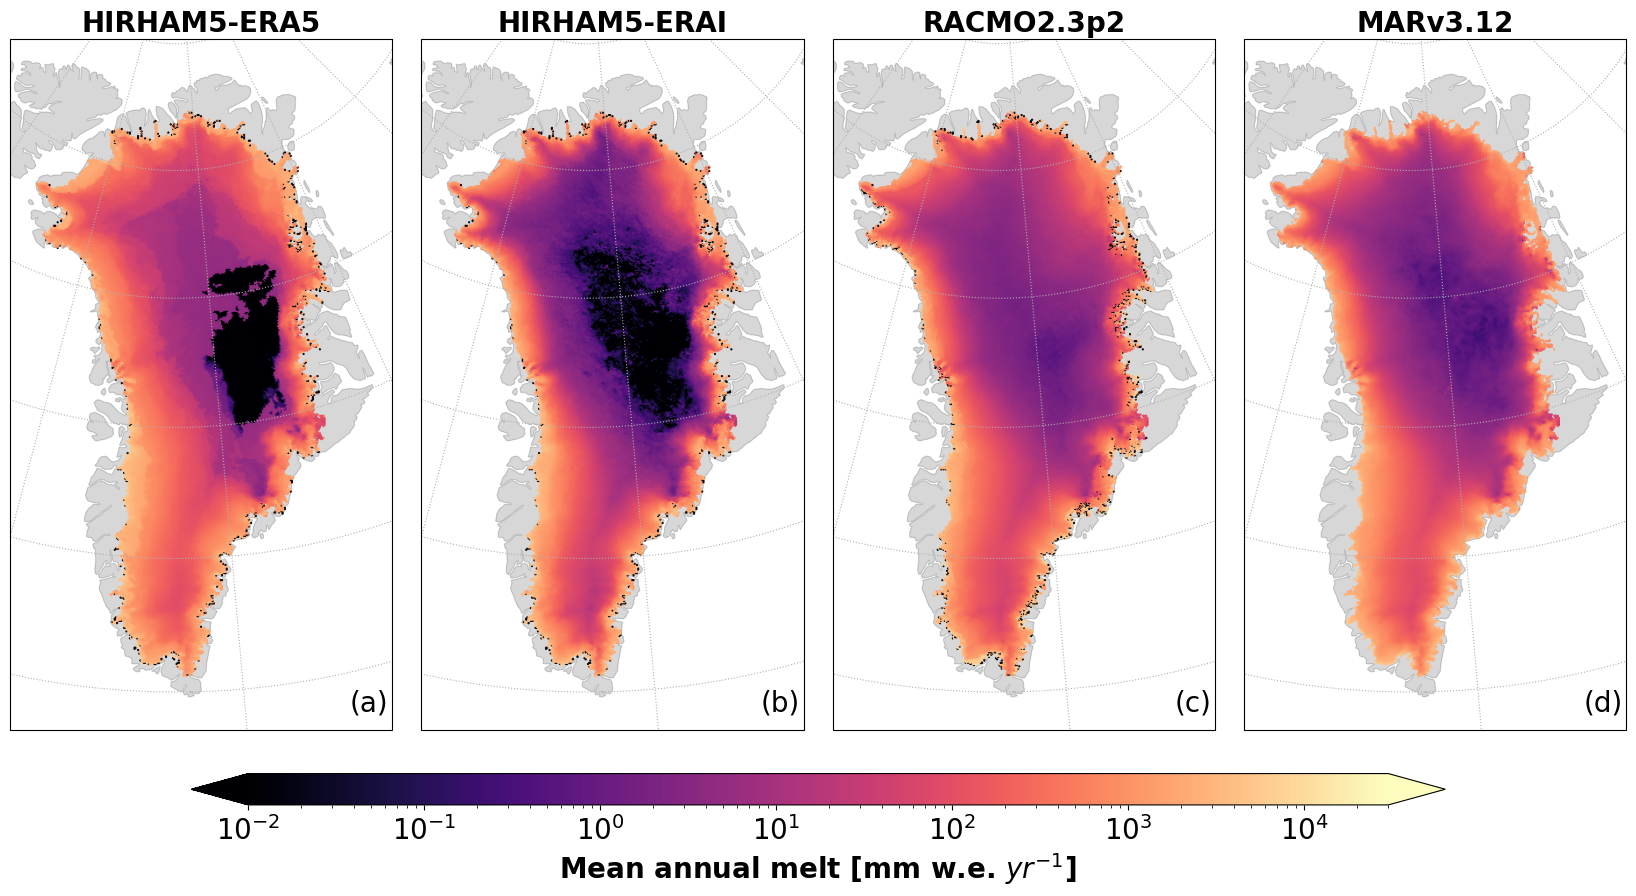

In [10]:
fig, axs = plt.subplots(1, 4, figsize = (15,6), subplot_kw={'projection': plot_proj})#, facecolor='#f1edec')

plot_melt_volume(np.mean(hirham_era5_sum, axis = 0), axs[0], vmin = 0, vmax = 1000, mask = ascat_mask)
axs[0].set_title('HIRHAM5-ERA5', fontweight = 'bold', fontsize = 20)
im = plot_melt_volume(np.mean(hirham_erai_sum, axis = 0), axs[1], vmin = 0, vmax = 1000, mask = ascat_mask)
axs[1].set_title('HIRHAM5-ERAI', fontweight = 'bold', fontsize = 20)

plot_melt_volume(np.mean(racmo_sum, axis = 0), axs[2], vmin = 0, vmax = 1000, mask = ascat_mask)
axs[2].set_title('RACMO2.3p2', fontweight = 'bold', fontsize = 20)
plot_melt_volume(np.mean(mar_sum, axis = 0), axs[3], vmin = 0, vmax = 1000, mask = ascat_mask)
axs[3].set_title('MARv3.12', fontweight = 'bold', fontsize = 20)

fig.tight_layout(pad = -10.5)
cbar = fig.colorbar(im, ax=axs[:], label = r'Mean annual melt [mm w.e. $yr^{-1}$]', location='bottom', shrink = 0.70, aspect = 40, pad=0.05, extend='both')
cbar.set_label(label = r'Mean annual melt [mm w.e. ${yr^{-1}}$]', fontsize=20, fontweight = 'bold')
cbar.ax.tick_params(labelsize=20)

# Add letter in the lower right corner 
for i, ax in enumerate(axs):
    ax.text(0.99, 0.02, f'({chr(97+i)})', transform=ax.transAxes, fontsize=20, va='bottom', ha='right')

## Plot of melt extent comparison: 

/var/folders/x2/ljhmp74x0fx3s82jfgwp27gm0000gp/T/ipykernel_93103/1517545195.py:22: RuntimeWarning: Mean of empty slice
  mean_annual_meltdays = np.nanmean(annual_meltdays, axis = 0) * unmasked
/var/folders/x2/ljhmp74x0fx3s82jfgwp27gm0000gp/T/ipykernel_93103/1517545195.py:24: RuntimeWarning: Mean of empty slice
  mean_ano = np.nanmean(annual_ano, axis = 0)


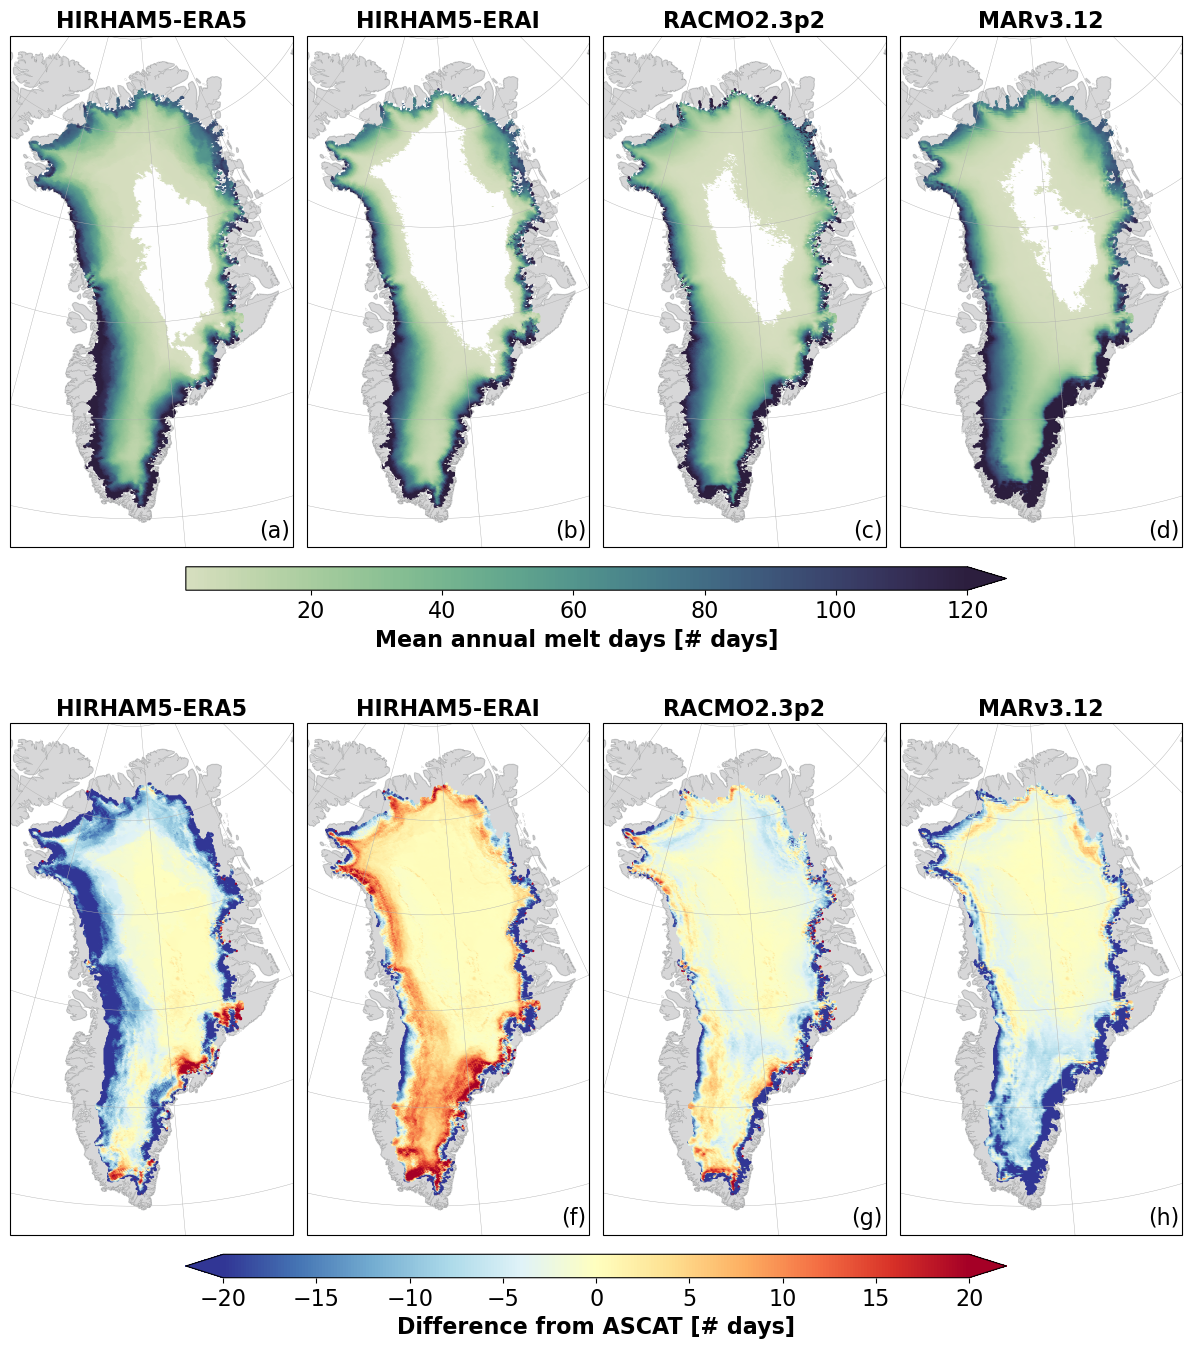

In [12]:
annual_meltdays = []
annual_ano = []

years = [2007, 2008, 2009, 2010,2011, 2012, 2013, 2014, 2015, 2016, 2017,2018,2020]
for yi in years: 
    meltdays_pickle = open_pickle(home_dir + f'/pickles/meltdays_{yi}_th_01.pkl')
    #melt_ratio_pickle = open_pickle(home_dir + f'/pickles/match_meltdays_{yi}.pkl')
    #refreeze_ratio_pickle = open_pickle(home_dir + f'/pickles/match_refreeze_{yi}.pkl')
    for j in range(0,5):
        meltdays_j = meltdays_pickle[j, :,:] 
        meltdays_j[(meltdays_j.astype(str)==str(np.nan)) & (mask.astype(str) != str(np.nan)) ] = 0
        meltdays_pickle[j,:,:] = meltdays_j
    
    annual_meltdays.append(meltdays_pickle)
    
    meltdays_diff = np.subtract(meltdays_pickle[0,:,:],meltdays_pickle[1:,:,:] )
    annual_ano.append(meltdays_diff)


# Convert to numpy array and apply mask:
annual_meltdays= np.array(annual_meltdays) * unmasked
mean_annual_meltdays = np.nanmean(annual_meltdays, axis = 0) * unmasked
annual_ano = np.array(annual_ano) * unmasked
mean_ano = np.nanmean(annual_ano, axis = 0)

# Plot: 
cmap = 'RdYlBu_r'
cmap2 = sns.cubehelix_palette(start=.5, rot=-.75, as_cmap=True)
fig, axs = plt.subplots(2, 4, figsize = (12,17), subplot_kw={'projection': plot_proj})

im = plot_greenland(mean_annual_meltdays[1,:,:], axs[0,0], mask = unmasked, 
               vmin = 0, vmax = 120, cmap = cmap2, text_label = '(a)')
axs[0,0].set_title('HIRHAM5-ERA5', fontweight = 'bold', fontsize = 16)
im.set_clim(0.99, 120)  # Set the color limits to exclude < 1
im.cmap.set_under('white')

im = plot_greenland(mean_annual_meltdays[2,:,:], axs[0,1], mask = unmasked, 
               vmin = 0, vmax = 120, cmap = cmap2, text_label = '(b)')
axs[0,1].set_title('HIRHAM5-ERAI', fontweight = 'bold', fontsize = 16)
im.set_clim(0.99, 120)  # Set the color limits to exclude < 1
im.cmap.set_under('white')

im = plot_greenland(mean_annual_meltdays[3,:,:], axs[0,2], mask = unmasked, 
               vmin = 0, vmax = 120, cmap = cmap2, text_label = '(c)')
axs[0,2].set_title('RACMO2.3p2', fontweight = 'bold', fontsize = 16)
im.set_clim(0.99, 120)  # Set the color limits to exclude < 1
im.cmap.set_under('white')

im = plot_greenland(mean_annual_meltdays[4,:,:], axs[0,3], mask =unmasked, 
               #cbar=True,
               cbar_label = f'MEAN [days]',
               vmin = 0, vmax = 120, cmap = cmap2, text_label = '(d)')
axs[0,3].set_title('MARv3.12', fontweight = 'bold', fontsize = 16)
im.set_clim(0.99, 120)  # Set the color limits to exclude < 1
im.cmap.set_under('white')

fig.tight_layout(pad = 1)
#fig.suptitle(f'ASCAT - RCM (2007-2020)', fontsize = 20)
cbar = fig.colorbar(im, ax=axs[0,:], location='bottom', 
                    shrink = 0.70, aspect = 35, pad=0.02, extend='max')
cbar.set_label('Mean annual melt days [# days]', fontsize=16, fontweight = 'bold')
cbar.ax.tick_params(labelsize=16)

plot_greenland(mean_ano[0,:,:], axs[1,0], mask = mask, 
               vmin = -20, vmax = 20, cmap = cmap)
axs[1,0].set_title('HIRHAM5-ERA5', fontweight = 'bold', fontsize = 16)

plot_greenland(mean_ano[1,:,:], axs[1,1], mask = mask, 
               vmin = -20, vmax = 20, cmap = cmap, text_label = '(f)')
axs[1,1].set_title('HIRHAM5-ERAI', fontweight = 'bold', fontsize = 16)

plot_greenland(mean_ano[2,:,:], axs[1,2], mask = mask, 
               vmin = -20, vmax = 20, cmap = cmap, text_label = '(g)')
axs[1,2].set_title('RACMO2.3p2', fontweight = 'bold', fontsize = 16)

im = plot_greenland(mean_ano[3,:,:], axs[1,3], mask =mask, 
               #cbar=True,
               cbar_label = f'MEAN [days]',
               vmin = -20, vmax = 20, cmap = cmap, text_label = '(h)')
axs[1,3].set_title('MARv3.12', fontweight = 'bold', fontsize = 16)

cbar = fig.colorbar(im, ax=axs[1,:], location='bottom', shrink = 0.70, aspect = 35, pad=0.02, extend='both')
cbar.set_label('Difference from ASCAT [# days]', fontsize=16, fontweight = 'bold')
cbar.ax.tick_params(labelsize=16)

## Plot of temporal evolution mean maximum melt extent

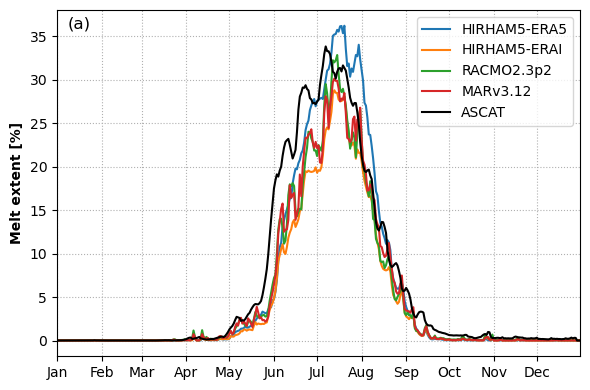

In [13]:
# dates for plotting (random year chosen):
dates = pd.date_range(f'01-01-2014', end=f'31-12-2014')

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(dates, np.mean(hirham_era5_stack, axis=0), label='HIRHAM5-ERA5')
ax.plot(dates, np.mean(hirham_erai_stack, axis=0), label='HIRHAM5-ERAI')
ax.plot(dates, np.mean(racmo_stack, axis=0), label='RACMO2.3p2')
ax.plot(dates, np.mean(mar_stack, axis=0), label='MARv3.12')
ax.plot(dates, np.mean(ascat_stack, axis=0), label='ASCAT', color='k')

ax.set_xlim(dates[0], dates[-1])
ax.set_ylabel('Melt extent [%]', fontweight='bold')
ax.legend()
ax.grid(linestyle=':')

# Set the x-axis tick labels to show only the month
locator = mdates.MonthLocator()
fmt = mdates.DateFormatter('%b')
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(fmt)

# Add letter in the upper left corner:
ax.text(0.02, 0.98, f'(a)', transform=ax.transAxes, fontsize=12, va='top', ha='left')
fig.tight_layout()

plt.savefig(home_dir + f'/figures/mean_melt_extent.png')